# Fitting

In [2]:
import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib import cm
import lmfit as lm
%matplotlib inline

### Misc. setup

In [3]:
# Just for good looks, no need to worry about this now.
# You are welcome to do this but it is not necessary.
c1 = cm.Reds(0.6)
c2 = cm.Blues(0.6)
c3 = cm.PuOr(0.3)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('font', size = 12)
plt.rc('lines', linewidth=3)
plt.rc('figure', figsize=(10.0, 7.0))

## Model Fitting

There are *many* different pieces of software around, because minimization problems are so common across much all fields of science and engineering. A few of the more well-known ones:

+ `scipy.curvefit`
+ `scipy.minimize`
+ Sherpa (developed by Chandra X-ray Centre)
+ Iminuit
+ LMfit - **The one we shall use here**
+ `astropy.modeling` - **In early development and not feature complete**

...And many more. They have very different interfaces, some are very simple and bare-bones, others are jam-packed with features; some are very specialized, some are more general. In this session we shall look at **LMfit**, which is basically a nicer, mmore user friendly wrapper around `scipy.optimize`. It is in the simpler, more general end. Some characteristics of LMfit:

* Few built-in models (???)
* Software is "dumb": it only minimizes the output of a function. Writing the right function is up to the user.
* Even error weighing is up to the user.
* Better parameter and fit quality handling than `scipy.optimize`.

### A simple example:

$$ f(x) = sin(a+x) + b $$

Find $a$ and $b$.

**First**, we create a fake dataset

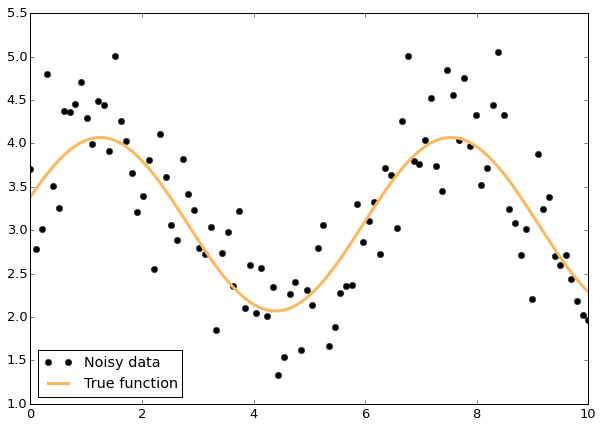

In [4]:
# Create faux data
xx = np.linspace(0, 10, 100)  # + np.random.random(100) * 0.02
a, b = np.random.normal() * 0.5, 1.2 + np.random.normal()
yy = np.sin(xx + a) + b
noisy_data = yy + np.random.randn(100) * 0.5

# Plot it just to have an idea how it looks
plt.plot(xx, noisy_data, 'ko', label='Noisy data')
plt.plot(xx, yy, '-', color=c3, label='True function')
plt.legend(loc='best')
plt.show()

LMFit keeps track of uncertainties, correlations etc. og free parameters in a `Parameters()` object, which must be passed to the minimizer which then varies these and passes them on to the function it minimizes.

LMfit requires a specific call sequence: `function_name(parameters, independent variable, data)`. In this, `parameters` is a lmfit `Parameters()` object.

We here define the `Parameters()` object and fill in some sane initial guesses, and then define the function to minimize in terms of these parameters:

In [5]:
pars = lm.Parameters()
pars.clear()
pars.add('a', 0)
pars.add('b', 1.2)

In [6]:
def sine_function(pars, x, data):
    '''A very simple function to fit'''
    # Unpack parameters
    a = pars['a'].value
    b = pars['b'].value
    return np.sin(x + a) + b - data

Now, we perform the minimization. The `minimize()` function must alaso be called with a speciala caall sequence: 

```python
lm.minimize(residual_function, Parameters(), 
    args=(arg1, arg2), 
    kws={'key1':value1, 'key2':value2}, 
    **kwargs)
```

Here, `args` and `kws` are positional arguments ans keyword arguments to be passed to the residual function. `**kwargs` is keyword arguments to the `minimizer()` function, e.g. the minimizer algorithm. See `help(lm.minimize)` or `lm.minimize?` for more. 

In [7]:
result = lm.minimize(sine_function, pars, args=(xx, noisy_data), 
                     method='leastsq')
lm.report_fit(pars)
print('Original parameters: a={}, b={}'.format(a, b))  # For comparison

[[Variables]]
     a:     0.2896029 +/- 0.07097785 (24.51%) initial =  0
     b:     3.111001 +/- 0.05081503 (1.63%) initial =  1.2
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      =  0.142 
Original parameters: a=0.318457177662, b=3.06854106367


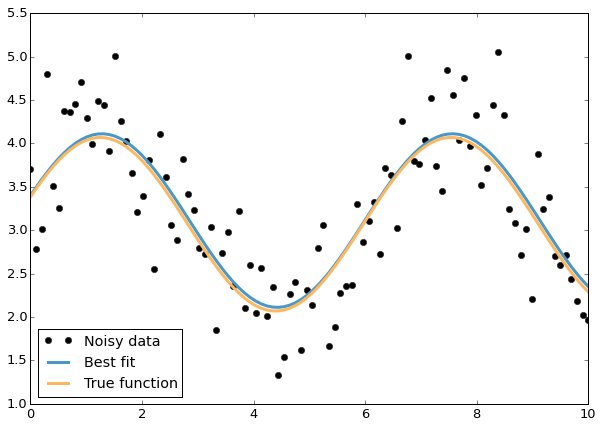

In [8]:
plt.plot(xx, noisy_data, 'ko', label='Noisy data')
plt.plot(xx, np.sin(xx + pars['a'].value) + pars['b'].value, '-', 
         color=c2, label='Best fit')
plt.plot(xx, yy, color=c3, label='True function')
plt.legend(loc='best')
plt.show()

Not half bad. 

## Fitting error-weighted data

**Plus: separating the residuals function from the model**

### First, we generate some new fake data

We add a little systematic error to give a more visible difference between weighted and non-weighted data.

In [14]:
###====================================================================
#        GENERATE FAKE DATA; NOT NECESSARY TO UNDERSTAND
#  Add systematic error to  data to better see difference 
#    between weighted and non-weighted fit:
noisy_data = (yy + np.random.randn(100) * 0.5) + xx * .08
#  Fake uncertainties, grow with systematic error (not unrealistic!)
stddev = np.absolute(np.random.random(len(xx))) * 0.5 + xx * 0.05
###====================================================================

### Define the model and the residuals functions

*(Remember: Residuals = remainder when model is subtracted from data.)*

This approach allows us to call the model function to generate a nice plot or otherwise comparae it to whatever we want. The residuals function takes care of all the rest that `lmfit` needs.

The minimum sum of squared residuals is the **BLUE** (**B**est **L**inear **U**nbiased **E**stimator) if the data have the same uncertainty. 

If not, the residuals should be weighted by the ***Inverse squared standaard errors*** (= inverse variance) over each data point, so that we minimize:
$$\sum_i \frac{y_i^2}{\sigma_i^2}, $$
where $y_i$ is the $i$th data point.

In [15]:
def sine_func(x, a, b):
    return np.sin(x + a) + b

def resids_sine(pars, x, data, stddev=None):
    a = pars['a'].value
    b = pars['b'].value
    model = sine_func(x, a, b)
    if stddev is None:
        resids = model - data
    else:
        # We must take the square root because the mimimizer 
        #   squares this before summing 
        resids = np.sqrt((model - data) ** 2. / stddev ** 2.)
    return resids

### Set new parameters, fit without errors:

In [16]:
new_pars = lm.Parameters()
new_pars.clear()
new_pars.add('a', 0)
new_pars.add('b', 1.2)

result_unweighed = lm.minimize(resids_sine, new_pars, 
                               args=(xx, noisy_data), kws={'stddev':None})
lm.report_fit(pars)
a_unweigh, b_unweigh = new_pars['a'].value, new_pars['b'].value

[[Variables]]
     a:     0.2896029 +/- 0.07097785 (24.51%) initial =  0
     b:     3.111001 +/- 0.05081503 (1.63%) initial =  1.2
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      =  0.142 


### Reset params, fit with error weighting

In [17]:
new_pars.clear()
new_pars.add('a', 0)
new_pars.add('b', 1.2)

result = lm.minimize(resids_sine, new_pars, args=(xx, noisy_data), 
                     kws={'stddev':stddev})
lm.report_fit(new_pars)
a_weigh, b_weigh = new_pars['a'].value, new_pars['b'].value

[[Variables]]
     a:     0.07368466 +/- 0.08083251 (109.70%) initial =  0
     b:     3.319837 +/- 0.05758492 (1.73%) initial =  1.2
[[Correlations]] (unreported correlations are <  0.100)


### Plot of data, true function, weighted and unweightwed fit

**Notice** how the weighted fit is closer to the true function than the unweighted one. This should not come as a surprise, but it is nice to see that it works.

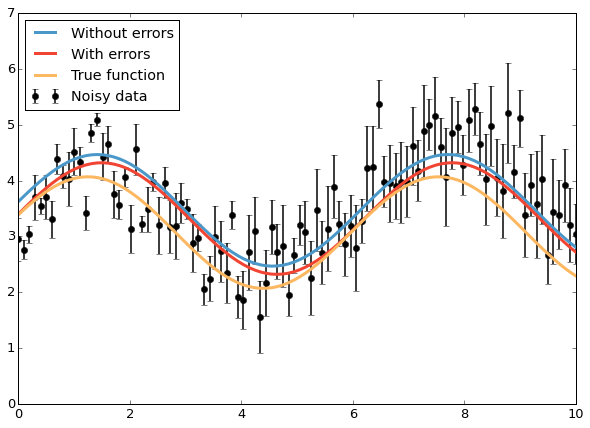

In [18]:
plt.errorbar(xx, noisy_data, stddev, color='k', marker='o', ls='', 
    elinewidth=1.5, label='Noisy data')
plt.plot(xx, np.sin(xx + a_unweigh) + b_unweigh, '-', color=c2,
    label='Without errors')
plt.plot(xx, np.sin(xx + a_weigh) + b_weigh, '-', color=c1,
    label='With errors')
plt.plot(xx, yy, color=c3, label='True function')
plt.legend(loc='best')
plt.show()

## Addendum: more difficult cases

Instead of:

$$ f(x) = sin(x + a) + b, $$

let us try the more difficult function:

$$ f(x) = a \cdot sin(bx + cos(cx)) + d $$


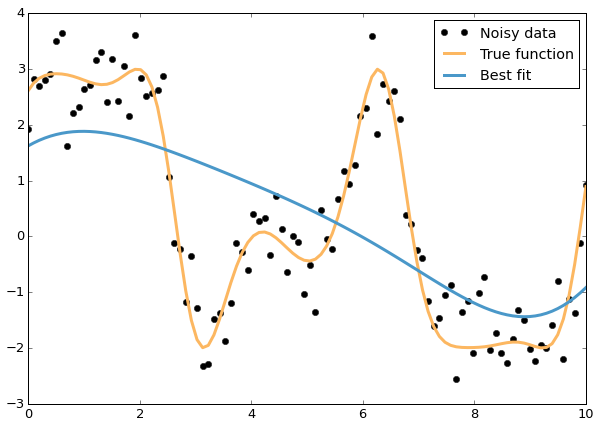

In [20]:
def hard_function(x, a, b, c, d):
    return a*np.sin(b*x + np.cos(c*x)) + d

def resids_hard_function(pars, x, data, stddev=None):
    a = pars['a'].value
    b = pars['b'].value
    c = pars['c'].value
    d = pars['d'].value
    model = hard_function(x, a, b, c, d)
    if stddev is None:
        resids = model - data
    else:
        resids = np.sqrt((model - data) ** 2. / stddev ** 2.)
    return resids

# We'll choose some parameters
true_pars = np.array([2.5, 1.3, 1.7, 0.5])
a, b, c, d = true_pars[0], true_pars[1], true_pars[2], true_pars[3]
yy = hard_function(xx, a, b, c, d)
noisy_data = yy + np.random.randn(100) * 0.5

# Set lmfit parameters with first guesses:
guess = np.random.rand(len(true_pars))# + true_pars 
pars = lm.Parameters()
pars.clear()
pars.add('a', guess[0])
pars.add('b', guess[1])
pars.add('c', guess[2])
pars.add('d', guess[3])

result = lm.minimize(resids_hard_function, pars, args=(xx, noisy_data))
best_fit_curve = hard_function(xx, pars['a'].value, pars['b'].value, 
                               pars['c'].value, pars['d'].value)

###==================================================================
# Never mind the plotting
plt.plot(xx, noisy_data, 'ko', label='Noisy data')
plt.plot(xx, yy, color=c3, ls='-', label='True function')
plt.plot(xx, best_fit_curve, color=c2, label='Best fit')
plt.legend(loc='best')
plt.show()

Ugh. Not good. Wonder what we can do about that?

### Exercises:

1. Try using different [fitting methods](http://lmfit.github.io/lmfit-py/fitting.html#fit-methods-table) and see if they work better.
2. Try to think of, and possibly implement, a method to get around this problem using only the `leastsq` fitting method.

(24.386240418162433, 24.386240418250008)
2


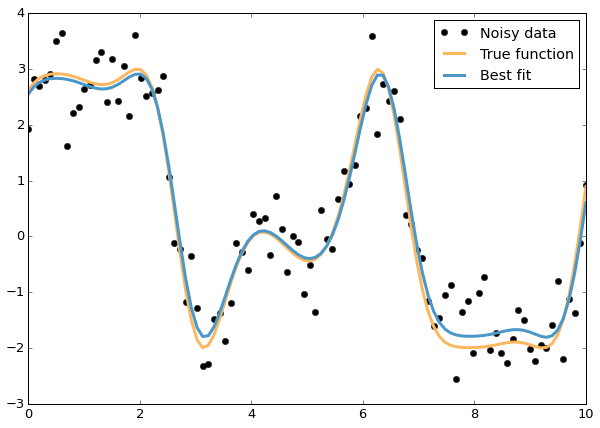

In [24]:
threshold = 30

red_chi_sq = 100
it = 0 
maxit = 10
mincs = 100
while red_chi_sq > threshold:
    # Draw random guesses from some sane parameter intervals
    guess = np.random.rand(len(true_pars))# * 2
    pars = lm.Parameters()
    pars.clear()
    pars.add('a', guess[0])
    pars.add('b', guess[1])
    pars.add('c', guess[2])
    pars.add('d', guess[3])
    result = lm.minimize(resids_hard_function, pars, 
                         args=(xx, noisy_data), 
                         method='leastsq')
    red_chi_sq = result.chisqr
    if red_chi_sq < mincs: 
        mincs = red_chi_sq
    it += 1
    if it > maxit:
        break

result = lm.minimize(resids_hard_function, pars, 
                     args=(xx, noisy_data), 
                     method='leastsq')
#print(red_chi_sq)
print(result.chisqr, mincs)
print(it)
best_fit_curve = hard_function(xx, pars['a'].value, pars['b'].value, 
                               pars['c'].value, pars['d'].value)

###==================================================================
# Never mind the plotting
plt.plot(xx, noisy_data, 'ko', label='Noisy data')
plt.plot(xx, yy, color=c3, ls='-', label='True function')
plt.plot(xx, best_fit_curve, color=c2, label='Best fit')
plt.legend(loc='best')
plt.show()

# Extra exercises

1. Write a gaussian function which takes as input an x-array, and the     
    parameters ammplitude, fwhm and center.
2. Make a modified version of the above residuals/function which works 
    with your Gaussian.
3. Write some more functions, all in the same textfile called 'models.py' 
    and save it in your current working directory. Try importing it.
3. (*Hard*) Try to write a residuals-function which works with *any* model.
